#### ⚔ **Property Of: Kunal Shah, Rishil Sheth, Gaurav Shipurkar & Tanish Surana** ⚔


# Downloading IAM_Word Dataset

In [1]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [2]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


# Imports & Creation Of Files

In [3]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import numpy as np
import random
import cv2
import os

In [4]:
data_location = '/content/data/words'
words_txt_location = '/content/data/words.txt'

In [5]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [6]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [7]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths_and_gts = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        last = line_split[-1]
        if os.path.getsize(img_path):
            paths_and_gts.append([img_path,last])
        
    return paths_and_gts


train_files = get_image_paths_and_labels(train_samples)
validation_files = get_image_paths_and_labels(validation_samples)
test_files = get_image_paths_and_labels(test_samples)

# Preprocessing

In [8]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """

    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    img /= 255
    return img

In [9]:
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
           '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

num_classes = len(letters) + 1
print(num_classes)

80


In [10]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

In [11]:
class TextImageGenerator:
    
    def __init__(self, data,
                 img_w,
                 img_h, 
                 batch_size, 
                 i_len,
                 max_text_len):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = preprocess(img_filepath, self.img_w, self.img_h)
            self.imgs[i, :, :] = img
            self.texts.append(text)
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.i_len
            label_length = np.zeros((self.batch_size, 1))
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i, :len(text)] = text_to_labels(text)
                label_length[i] = len(text)
                
            inputs = [X_data, Y_data, input_length, label_length]
            outputs = np.zeros([self.batch_size])
            yield (inputs, outputs)

In [12]:
batch_size = 64
input_length = 30
max_text_len = 21
img_w = 128
img_h = 64

In [13]:
train_data = TextImageGenerator(train_files, img_w, img_h, batch_size, input_length, max_text_len)
train_data.build_data()

In [14]:
train_data.imgs.shape

(86808, 64, 128)

In [15]:
validation_data = TextImageGenerator(validation_files, img_w, img_h, batch_size, input_length, max_text_len)
validation_data.build_data()

In [16]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

# Model

In [17]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32') 
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2),strides=2,name='max1')(iam_layers) 

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2),strides=2,name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2),strides=2, name='max3')(iam_layers)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)


iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2),strides=2, name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)


iam_layers = layers.Reshape(target_shape=((32, 512)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)

iam_layers = layers.BatchNormalization()(iam_layers)

iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[21], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 64, 64)  640         ['the_input[0][0]']              
                                                                                                  
 activation (Activation)        (None, 128, 64, 64)  0           ['conv1[0][0]']                  
                                                                                                  
 max1 (MaxPooling2D)            (None, 64, 32, 64)   0           ['activation[0][0]']         

In [18]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics = ['accuracy'])

# Training

In [19]:
import time
from tensorflow.keras.callbacks import Callback

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        print(" ;validation took {} minutes.".format(cur_test_time))

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_save_cb = ModelCheckpoint(filepath='/content/drive/MyDrive/HandwrittingRecognition/Saved_Weights_Keras/two-weights-epoch{epoch:02d}-acc{accuracy:.3f}-val_acc{val_accuracy:.3f}--loss{loss:.3f}-val_loss{val_loss:.3f}.h5', verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
# earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min')
# reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)
epoch_times = EpochTimeHistory()

In [21]:
!rm -r '/content/drive'

rm: cannot remove '/content/drive': No such file or directory


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
batch_size, train_data.n, validation_data.n

(64, 86808, 4823)

In [24]:
history_model_3 = model.fit( train_data.next_batch(), validation_data=validation_data.next_batch(), steps_per_epoch=train_data.n/batch_size, validation_steps=validation_data.n // batch_size, epochs=50, callbacks=[model_save_cb, epoch_times])

Epoch 1/50
1357/1356 [==============================] - ETA: 0s - loss: 9.8704 - accuracy: 0.1150 ;validation took 0.0925 minutes.

Epoch 1: saving model to /content/drive/MyDrive/HandwrittingRecognition/Saved_Weights_Keras/two-weights-epoch01-acc0.115-val_acc0.235--loss9.870-val_loss6.524.h5
 ;epoch 1 took 2.3108 minutes.
1356/1356 [==============================] - 139s 88ms/step - loss: 9.8704 - accuracy: 0.1150 - val_loss: 6.5240 - val_accuracy: 0.2350
Epoch 2/50
1357/1356 [==============================] - ETA: 0s - loss: 4.0593 - accuracy: 0.3398 ;validation took 0.0602 minutes.

Epoch 2: saving model to /content/drive/MyDrive/HandwrittingRecognition/Saved_Weights_Keras/two-weights-epoch02-acc0.340-val_acc0.385--loss4.059-val_loss3.421.h5
 ;epoch 2 took 1.9545 minutes.
1356/1356 [==============================] - 117s 86ms/step - loss: 4.0593 - accuracy: 0.3398 - val_loss: 3.4205 - val_accuracy: 0.3848
Epoch 3/50
1357/1356 [==============================] - ETA: 0s - loss: 2.5885

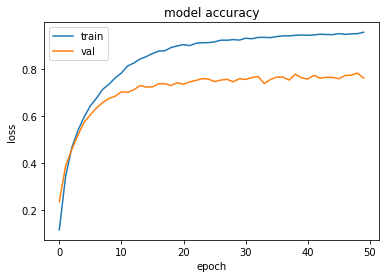

In [25]:
plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

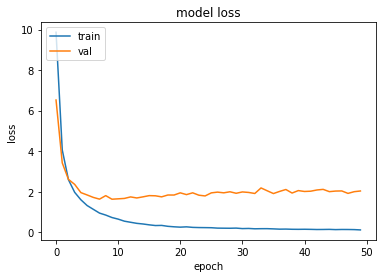

In [26]:
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing 

In [ ]:
iam_model_pred = None
iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)
iam_model_pred.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 128, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 64, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 128, 64, 64)      256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 64, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 64, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 32, 128)       73856     
                                                           

In [ ]:
iam_model_pred.load_weights(filepath='/content/drive/MyDrive/HandwrittingRecognition/Saved_Weights/two-weights-epoch32-acc0.943-val_acc0.821--loss0.148-val_loss1.261.h5')

In [ ]:
test_images_processed = []
original_test_texts = []
for _, (test_image_path, original_test_text) in enumerate(test_files):
     temp_processed_image = preprocess(path=test_image_path, img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(original_test_text)

In [ ]:
test_images_processed = np.array(test_images_processed)
test_images_processed.shape

(4823, 128, 64)

In [ ]:
test_predictions_encoded = iam_model_pred.predict(x=test_images_processed)
test_predictions_decoded = tf_keras_backend.get_value(tf_keras_backend.ctc_decode( test_predictions_encoded, input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1], greedy=True)[0][0])
test_predictions_decoded.shape

(4823, 32)

In [ ]:
def numbered_array_to_text(numbered_array):
    numbered_array = numbered_array[numbered_array != -1]
    return "".join(letters[i] for i in numbered_array)

In [ ]:
for i in range(20):
  print("Original Text = ", original_test_texts[i])
  print("Predicted Text = ", numbered_array_to_text(test_predictions_decoded[i]))
  print("\n")

Original Text =  bushes
Predicted Text =   bushes


Original Text =  ,
Predicted Text =   !,


Original Text =  of
Predicted Text =   of


Original Text =  man
Predicted Text =   man


Original Text =  married
Predicted Text =   married


Original Text =  Trebling
Predicted Text =   Brelling


Original Text =  and
Predicted Text =   and


Original Text =  Passover
Predicted Text =  Passover


Original Text =  "
Predicted Text =   "


Original Text =  list
Predicted Text =   list


Original Text =  George
Predicted Text =  George


Original Text =  This
Predicted Text =   This


Original Text =  better
Predicted Text =   better


Original Text =  given
Predicted Text =   Ggiven


Original Text =  her
Predicted Text =   Ther


Original Text =  succeeded
Predicted Text =   succeeded


Original Text =  .
Predicted Text =   !.


Original Text =  of
Predicted Text =   of


Original Text =  his
Predicted Text =   his


Original Text =  ,
Predicted Text =   !,




# Single Image

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import numpy as np
import random
import cv2
import os

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

In [ ]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32') 
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers) 

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)


iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)

iam_layers = layers.BatchNormalization()(iam_layers)

iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[21], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 64, 64)  640         ['the_input[0][0]']              
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128, 64, 64)  256        ['conv1[0][0]']                  
 rmalization)                                                                                     
                                                                                            

In [ ]:
iam_model_pred = None
iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)
iam_model_pred.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 128, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 64, 64)       640       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 64, 64)      256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 128, 64, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 64, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 32, 128)       73856     
                                                           

In [ ]:
test_images_processed = np.array(test_images_processed)
test_images_processed.shape

In [ ]:
from unittest import result
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
import cv2
from pathlib import Path
from tensorflow.keras import backend as tf_keras_backend


class Predictions:

    def __init__(self, link):

        p = Path(link)
        self.make_model()
        self.store = []
        self.result = []
        for pa in p.iterdir():
            self.make_predictions(str(pa))

        self.result.append(self.store)

    def make_model(self):

        input_data = layers.Input(name='the_input', shape=(128, 64, 1), dtype='float32')
        iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
        iam_layers = layers.BatchNormalization()(iam_layers)
        iam_layers = layers.Activation('relu')(iam_layers)
        iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers)

        iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
        iam_layers = layers.BatchNormalization()(iam_layers)
        iam_layers = layers.Activation('relu')(iam_layers)
        iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

        iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
        iam_layers = layers.BatchNormalization()(iam_layers)
        iam_layers = layers.Activation('relu')(iam_layers)

        iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
        iam_layers = layers.BatchNormalization()(iam_layers)
        iam_layers = layers.Activation('relu')(iam_layers)
        iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)

        iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
        iam_layers = layers.BatchNormalization()(iam_layers)
        iam_layers = layers.Activation('relu')(iam_layers)

        iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
        iam_layers = layers.BatchNormalization()(iam_layers)
        iam_layers = layers.Activation('relu')(iam_layers)
        iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

        iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
        iam_layers = layers.BatchNormalization()(iam_layers)
        iam_layers = layers.Activation('relu')(iam_layers)

        iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
        iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)
        iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)

        iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
        iam_layers = layers.BatchNormalization()(iam_layers)

        iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
        iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

        # Creating the Model
        self.iam_model_pred = None
        self.iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)

    def add_padding(self, img, old_w, old_h, new_w, new_h):

        h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
        w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
        img_pad = np.ones([new_h, new_w, 3]) * 255
        img_pad[h1:h2, w1:w2, :] = img
        return img_pad

    def fix_size(self, img, target_w, target_h):
        h, w = img.shape[:2]
        if w < target_w and h < target_h:
            img = self.add_padding(img, w, h, target_w, target_h)
        elif w >= target_w and h < target_h:
            new_w = target_w
            new_h = int(h * new_w / w)
            new_img = cv2.resize(img, (new_w, new_h),
                                 interpolation=cv2.INTER_AREA)
            img = self.add_padding(new_img, new_w, new_h, target_w, target_h)
        elif w < target_w and h >= target_h:
            new_h = target_h
            new_w = int(w * new_h / h)
            new_img = cv2.resize(img, (new_w, new_h),
                                 interpolation=cv2.INTER_AREA)
            img = self.add_padding(new_img, new_w, new_h, target_w, target_h)
        else:
            """w>=target_w and h>=target_h """
            ratio = max(w / target_w, h / target_h)
            new_w = max(min(target_w, int(w / ratio)), 1)
            new_h = max(min(target_h, int(h / ratio)), 1)
            new_img = cv2.resize(img, (new_w, new_h),
                                 interpolation=cv2.INTER_AREA)
            img = self.add_padding(new_img, new_w, new_h, target_w, target_h)
        return img

    def preprocess(self, path, img_w, img_h):
        """ Pre-processing image for predicting """
        img = cv2.imread(str(path))
        img = self.fix_size(img, img_w, img_h)

        img = np.clip(img, 0, 255)
        img = np.uint8(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        img = img.astype(np.float32)
        img /= 255
        return img

    def numbered_array_to_text(self, numbered_array):

        letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                   '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
                   'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                   'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                   'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                   'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

        numbered_array = numbered_array[numbered_array != -1]
        return "".join(letters[i] for i in numbered_array)

    def make_predictions(self, pa):

        self.iam_model_pred.load_weights(filepath=r'/content/drive/MyDrive/HandwrittingRecognition/Saved_Weights/two-weights-epoch32-acc0.943-val_acc0.821--loss0.148-val_loss1.261.h5')
        test_images_processed = []
        temp_processed_image = self.preprocess(path=pa, img_w=128, img_h=64)
        test_images_processed.append(temp_processed_image.T)
        test_images_processed = np.array(test_images_processed)
        test_predictions_encoded = self.model.predict(x=test_images_processed)
        test_predictions_decoded = tf_keras_backend.get_value(tf_keras_backend.ctc_decode(test_predictions_encoded, input_length=np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1], greedy=True)[0][0])
        print(self.numbered_array_to_text(test_predictions_decoded))
        self.store.append(self.numbered_array_to_text(test_predictions_decoded))


# Original Model

In [ ]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32') 
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers) 

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)


iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)

iam_layers = layers.BatchNormalization()(iam_layers)

iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[21], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

**Changed Model**

In [ ]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32') 
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2),strides=2,name='max1')(iam_layers) 

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2),strides=2,name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2),strides=2, name='max3')(iam_layers)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)


iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2),strides=2, name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)


iam_layers = layers.Reshape(target_shape=((32, 512)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)

iam_layers = layers.BatchNormalization()(iam_layers)

iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[21], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()